<a href="https://colab.research.google.com/github/pshemach/Computer-Vision/blob/main/Transfer_Learning_Fine_tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
print('Hello World,')

Hello World,


In [ ]:
import os
import matplotlib.pyplot as plt
import zipfile

import tensorflow as tf
import numpy as np

In [ ]:
!wget https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip

--2024-02-28 03:50:18--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.97.207, 142.250.157.207, 142.251.8.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.97.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘cats_and_dogs_filtered.zip’

cats_and_dogs_filte 100%[===================>]  65.43M  21.7MB/s    in 3.0s    

2024-02-28 03:50:22 (21.7 MB/s) - ‘cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [ ]:
zip_ref = zipfile.ZipFile('cats_and_dogs_filtered.zip','r')
zip_ref.extractall()
zip_ref.close()

In [ ]:
for dirpath, dirname, filenames in os.walk('cats_and_dogs_filtered'):
  print(f'There are {len(dirname)} directories and {len(filenames)} images in {dirpath}')

There are 2 directories and 1 images in cats_and_dogs_filtered
There are 2 directories and 0 images in cats_and_dogs_filtered/validation
There are 0 directories and 500 images in cats_and_dogs_filtered/validation/cats
There are 0 directories and 500 images in cats_and_dogs_filtered/validation/dogs
There are 2 directories and 0 images in cats_and_dogs_filtered/train
There are 0 directories and 1000 images in cats_and_dogs_filtered/train/cats
There are 0 directories and 1000 images in cats_and_dogs_filtered/train/dogs


In [ ]:
train_dir = 'cats_and_dogs_filtered/train'
validation_dir = 'cats_and_dogs_filtered/validation'

In [ ]:
BATCH_SIZE = 32
IMAGE_SIZE = (160,160)

In [ ]:
train_data = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                         shuffle=True,
                                                         batch_size=BATCH_SIZE,
                                                         image_size=IMAGE_SIZE)

validation_data = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                              shuffle=True,
                                                              batch_size=BATCH_SIZE,
                                                              image_size=IMAGE_SIZE)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


In [ ]:
class_names = train_data.class_names

In [ ]:
len(train_data), len(validation_data)

(63, 32)

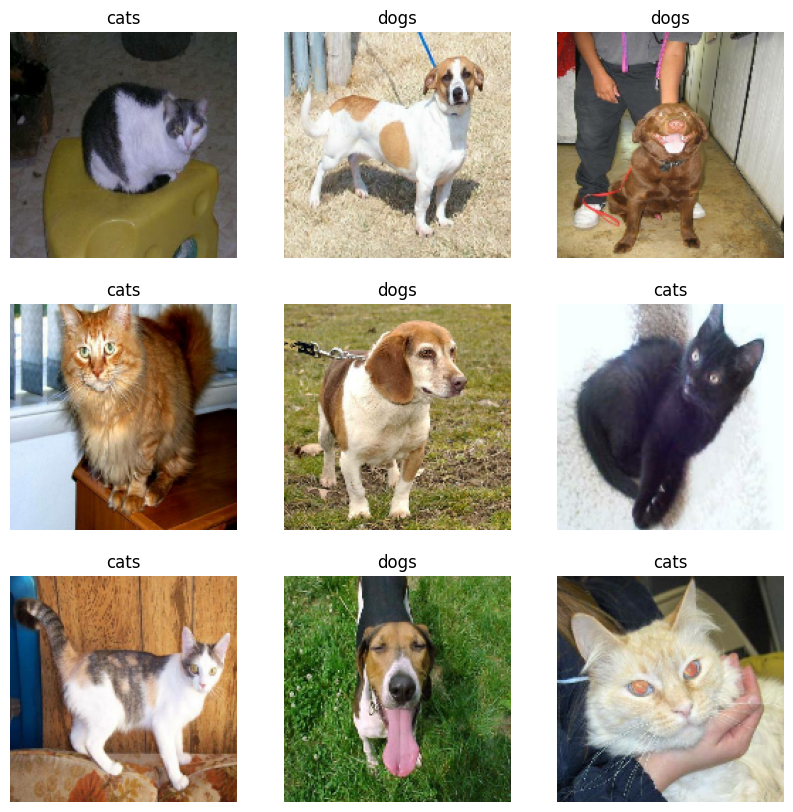

In [ ]:
plt.figure(figsize=(10,10))
for images, labels in train_data.take(1):
  for i in range(9):
    ax = plt.subplot(3,3, i+1)
    plt.imshow(images[i].numpy().astype('uint8'))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
val_batches = tf.data.experimental.cardinality(validation_data)
test_data = validation_data.take(val_batches//5)
validation_data = validation_data.skip(val_batches//5)

In [ ]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_data))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_data))

Number of validation batches: 26
Number of test batches: 6


In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_data = train_data.prefetch(buffer_size=AUTOTUNE)
test_data = test_data.prefetch(buffer_size=AUTOTUNE)
validation_data = validation_data.prefetch(buffer_size=AUTOTUNE)

In [ ]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomRotation(0.2)
])

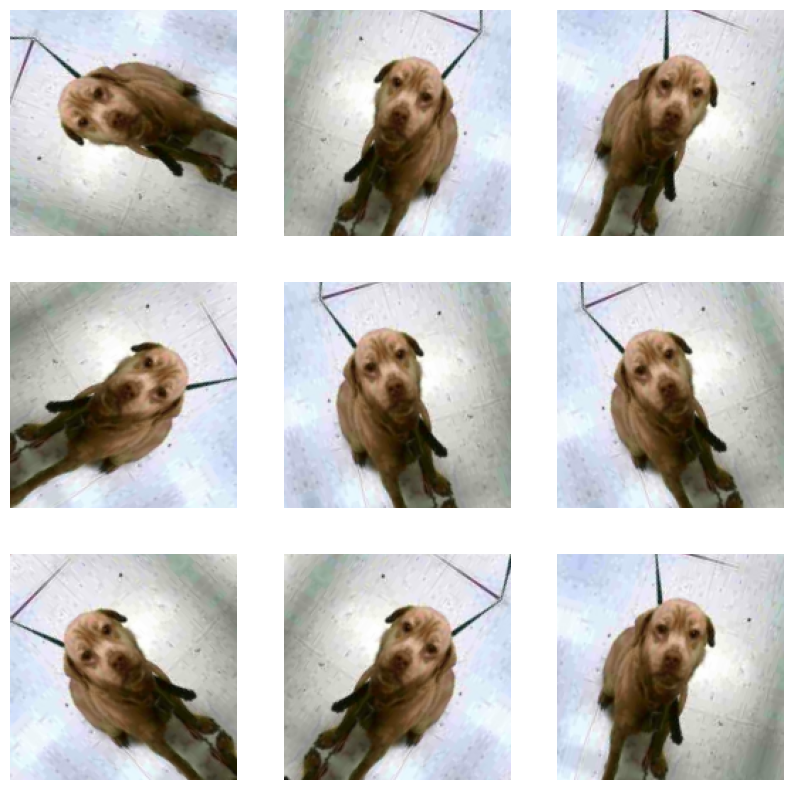

In [ ]:
plt.figure(figsize=(10,10))
for images, _ in train_data.take(1):
  for i in range(9):
    ax = plt.subplot(3,3, i+1)
    augmented_image = data_augmentation(tf.expand_dims(images[0], 0))
    plt.imshow(augmented_image[0]/255)
    plt.axis("off")

In [ ]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [ ]:
rescale = tf.keras.layers.Rescaling(1./127.5,offset=-1)

In [ ]:
IMAGE_SHAPE = IMAGE_SIZE + (3,)

In [ ]:
base_model = tf.keras.applications.MobileNetV2(input_shape=IMAGE_SHAPE,
                                                include_top=False,
                                                weights='imagenet')

9406464/9406464 [==============================] - 1s 0us/step


In [ ]:
image_batch, label_batch = next(iter(train_data))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 1280)


In [ ]:
base_model.trainable = False

In [ ]:
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 160, 160, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 80, 80, 32)           864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 80, 80, 32)           128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 80, 80, 32)           0         ['bn_Conv1[

In [ ]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [ ]:
prediction_layer = tf.keras.layers.Dense(1)

In [ ]:
inputs = tf.keras.Input(shape=(160,160,3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)

model = tf.keras.Model(inputs,outputs)

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambd  (None, 160, 160, 3)       0         
 a)                                                              
                                                                 
 tf.math.subtract (TFOpLamb  (None, 160, 160, 3)       0         
 da)                                                             
                                                                 
 mobilenetv2_1.00_160 (Func  (None, 5, 5, 1280)        2257984   
 tional)                                                         
                                                             

In [ ]:
len(model.trainable_variables)

2

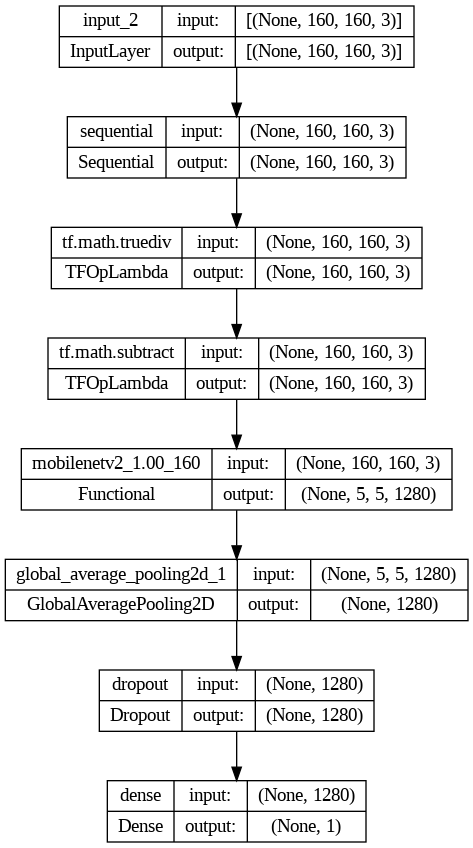

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [ ]:
base_lr = 0.0001

model.compile(loss = tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(learning_rate=base_lr),
              metrics=tf.keras.metrics.BinaryAccuracy(threshold=0, name='accuracy'))

In [ ]:
loss0, accuracy0 = model.evaluate(validation_data)

26/26 [==============================] - 17s 537ms/step - loss: 0.7800 - accuracy: 0.5446


In [ ]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 0.78
initial accuracy: 0.54


In [ ]:
epochs = 5

history = model.fit(train_data,
                    epochs=epochs,
                    validation_data=validation_data)

Epoch 1/5
63/63 [==============================] - 66s 957ms/step - loss: 0.7145 - accuracy: 0.5880 - val_loss: 0.5380 - val_accuracy: 0.7240
Epoch 2/5
63/63 [==============================] - 57s 892ms/step - loss: 0.5518 - accuracy: 0.7215 - val_loss: 0.4056 - val_accuracy: 0.8552
Epoch 3/5
63/63 [==============================] - 62s 991ms/step - loss: 0.4362 - accuracy: 0.8225 - val_loss: 0.3212 - val_accuracy: 0.8960
Epoch 4/5
63/63 [==============================] - 60s 960ms/step - loss: 0.3863 - accuracy: 0.8440 - val_loss: 0.2639 - val_accuracy: 0.9208
Epoch 5/5
63/63 [==============================] - 62s 971ms/step - loss: 0.3481 - accuracy: 0.8570 - val_loss: 0.2229 - val_accuracy: 0.9369


In [ ]:
model.evaluate(validation_data)

26/26 [==============================] - 18s 626ms/step - loss: 0.2277 - accuracy: 0.9381


[0.22766628861427307, 0.9381188154220581]

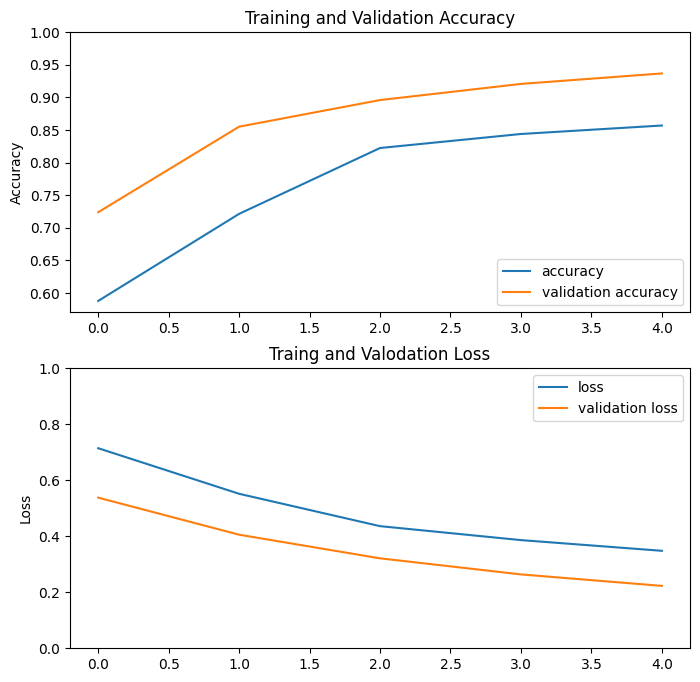

In [ ]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8,8))
plt.subplot(2,1,1)
plt.plot(accuracy, label='accuracy')
plt.plot(val_accuracy, label='validation accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.ylim([min(plt.ylim()),1])


plt.subplot(2,1,2)
plt.plot(loss, label='loss')
plt.plot(val_loss, label='validation loss')
plt.legend(loc='upper right')
plt.ylabel('Loss')
plt.title('Traing and Valodation Loss')
plt.ylim([0,1.0])
plt.show()